In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import math
import pandas as pd
import re
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
data = pd.read_csv('H:\geph_package_data\wireshark_encoded.csv')
data.head()

,No.,Time,Length,Source_Port,Destination_Port,Seq,Ack,Win,Len,Label,Protocol_TCP,"Protocol_TCP, HiPerConTracer"
0,2.0,0.000006,56.0,9809,41918,1,1,0,0,False,1,0
1,7.0,0.049032,68.0,44478,443,1,5481,766,0,False,1,0
2,8.0,0.049062,68.0,44478,443,1,8221,809,0,False,1,0
3,14.0,0.049135,2808.0,44478,443,1,13701,809,0,False,1,0
4,20.0,0.049160,2808.0,44478,443,1,40330,679,0,False,1,0


In [4]:
X = data.drop(columns=['Label']).values
y = data['Label'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert labels to integers if necessary
y = y.astype(int)

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = pd.concat([pd.DataFrame(X), pd.Series(y, name='Label')], axis=1)

# Separate majority and minority classes in the training set
majority = train_data[train_data['Label'] == 0]
minority = train_data[train_data['Label'] == 1]

# Downsample the majority class
majority_downsampled = resample(majority,
                                replace=False,     # Sample without replacement
                                n_samples=len(minority),  # Match the minority class size
                                random_state=42)  # Seed for reproducibility

# Combine the downsampled majority class with the minority class
train_data_balanced = pd.concat([majority_downsampled, minority])

# Shuffle the balanced training set
train_data_balanced = train_data_balanced.sample(frac=1, random_state=42)

# Separate features and labels
X_train_balanced = train_data_balanced.drop(columns=['Label']).values
y_train_balanced = train_data_balanced['Label'].values

# Convert balanced training data to PyTorch tensors
X_train = torch.tensor(X_train_balanced, dtype=torch.float32)
y_train = torch.tensor(y_train_balanced, dtype=torch.float32)
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
# Test set (unchanged)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [5]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.utils import resample


# # Separate the majority and minority classes
# majority = data[data['Label'] == 0]
# minority = data[data['Label'] == 1]

# # Downsample the majority class
# majority_downsampled = resample(majority,
#                                 replace=False,     # Sample without replacement
#                                 n_samples=len(minority),  # Match minority class size
#                                 random_state=42)  # Seed for reproducibility

# # Combine the downsampled majority class with the minority class
# data_balanced = pd.concat([majority_downsampled, minority])

# # Shuffle the dataset to mix the classes
# data_balanced = data_balanced.sample(frac=1, random_state=42)

# # Separate features and labels again
# X_balanced = data_balanced.drop(columns=["Label"]).values
# y_balanced = data_balanced["Label"].values

# # Perform train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# # Verify the class distribution
# print("Training set class distribution:")
# print(pd.Series(y_train).value_counts())
# print("Test set class distribution:")
# print(pd.Series(y_test).value_counts())
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
# # Test set (unchanged)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)


In [6]:
class WiresharkModel(nn.Module):
    def __init__(self, input_size):
        super(WiresharkModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)  # Output layer for binary classification
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # For binary output

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x


In [7]:
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        """
        Focal Loss for binary classification
        Args:
            alpha (float): Weighting factor for the positive class.
            gamma (float): Focusing parameter to reduce the relative loss for well-classified examples.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        """
        Compute Focal Loss
        Args:
            inputs (Tensor): Predicted probabilities (output of the model after sigmoid).
            targets (Tensor): Ground truth labels (0 or 1).
        Returns:
            Tensor: Computed Focal Loss.
        """
        bce_loss = nn.BCELoss(reduction='none')(inputs, targets)  # Binary cross-entropy loss
        pt = torch.exp(-bce_loss)  # Probability of the correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss  # Focal Loss formula
        return focal_loss.mean()

In [7]:
# # Model setup
input_size = X_train.shape[1]
model = WiresharkModel(input_size)
model = model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
# # Loss and optimizer
# criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# epochs = 20
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()

#     # Forward pass
#     outputs = model(X_train).squeeze()  # Squeeze to match y_train dimensions
#     loss = criterion(outputs, y_train)
    
#     # Backward pass
#     loss.backward()
#     optimizer.step()

#     # Print loss for the epoch
#     if (epoch + 1) % 5 == 0:
#         print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
# Initialize Focal Loss
criterion = FocalLoss(alpha=0.45, gamma=2.5)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train).squeeze()  # Squeeze to match y_train dimensions
    loss = criterion(outputs, y_train)
    
    # Backward pass
    loss.backward()
    optimizer.step()

    # Print loss for the epoch
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [5/20], Loss: 0.0474
Epoch [10/20], Loss: 0.0374
Epoch [15/20], Loss: 0.0284
Epoch [20/20], Loss: 0.0212


In [8]:
# Evaluation mode
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze()
    predictions = (predictions > 0.8).float()  # Convert probabilities to binary outputs

    # Calculate accuracy
    accuracy = (predictions == y_test).sum().item() / len(y_test)
    print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9563


In [9]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze()
    predictions_binary = (predictions > 0.8).int()  # Convert probabilities to binary predictions

y_test_tensor = y_test.int()

# Calculate False Negatives
false_negatives = ((predictions_binary == 0) & (y_test_tensor == 1)).sum().item()

false_positives = ((predictions_binary == 1) & (y_test_tensor == 0)).sum().item()

# True Positives
true_positives = ((predictions_binary == 1) & (y_test_tensor == 1)).sum().item()

# True Negatives
true_negatives = ((predictions_binary == 0) & (y_test_tensor == 0)).sum().item()

false_positive_rate = false_positives / (false_positives + true_negatives)
print(f"False Positive Rate: {false_positive_rate:.2f}")


False Positive Rate: 0.00


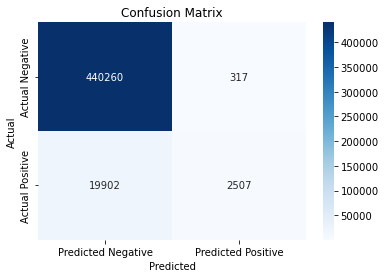

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_test = y_test.cpu()
predictions_binary = predictions_binary.cpu()
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Predicted Negative", "Predicted Positive"], 
            yticklabels=["Actual Negative", "Actual Positive"])

# Add labels and title
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


In [12]:
torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": loss,
}, "checkpoint.pth")

In [10]:
import torch

# Load the checkpoint
checkpoint = torch.load("checkpoint1.pth")
input_size = X_train.shape[1]
# Example model and optimizer definitions (must match the saved model)
model = WiresharkModel(input_size)  # Replace with your model class
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Replace with your optimizer

# Load the model and optimizer state dicts
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# Load additional metadata if available
epoch = checkpoint.get("epoch", None)
loss = checkpoint.get("loss", None)

# Set the model to evaluation or training mode
model.eval()  # For evaluation
# model.train()  # For resuming training

print(f"Model and optimizer states loaded successfully! (Epoch: {epoch}, Loss: {loss})")


Model and optimizer states loaded successfully! (Epoch: 19, Loss: 0.02123773656785488)


In [12]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze()
    predictions_binary = (predictions > 0.8).int()  # Convert probabilities to binary predictions

y_test_tensor = y_test.int()

# Calculate False Negatives
false_negatives = ((predictions_binary == 0) & (y_test_tensor == 1)).sum().item()

false_positives = ((predictions_binary == 1) & (y_test_tensor == 0)).sum().item()

# True Positives
true_positives = ((predictions_binary == 1) & (y_test_tensor == 1)).sum().item()

# True Negatives
true_negatives = ((predictions_binary == 0) & (y_test_tensor == 0)).sum().item()

false_positive_rate = false_positives / (false_positives + true_negatives)
print(f"False Positive Rate: {false_positive_rate:.2f}")


False Positive Rate: 0.00


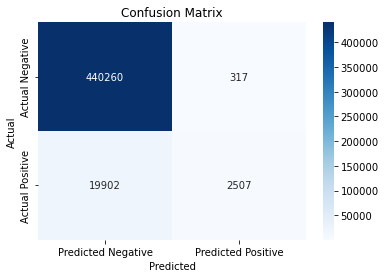

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_test = y_test.cpu()
predictions_binary = predictions_binary.cpu()
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions_binary)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Predicted Negative", "Predicted Positive"], 
            yticklabels=["Actual Negative", "Actual Positive"])

# Add labels and title
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()
